# Assignment 3

Imports

In [140]:
import numpy as np
import scipy as sp
from scipy.optimize import dual_annealing, curve_fit
from scipy.integrate import solve_ivp, odeint
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import pandas as pd
from tqdm import tqdm
from numba import jit, njit, prange
import math
import os
import random

In [141]:
SEED = 33
np.random.seed(SEED)

os.makedirs('media', exist_ok=True)

if not os.path.isfile('predator-prey-data.csv'):
    raise FileNotFoundError("File 'predator-prey-data.csv' not found.")

data = pd.read_csv('predator-prey-data.csv')

In [142]:
LOW_PARAM_BOUND = 0
UP_PARAM_BOUND = 2
MAX_STEPS_HILLCLIMING = 500
MAX_ITER_SA = 100

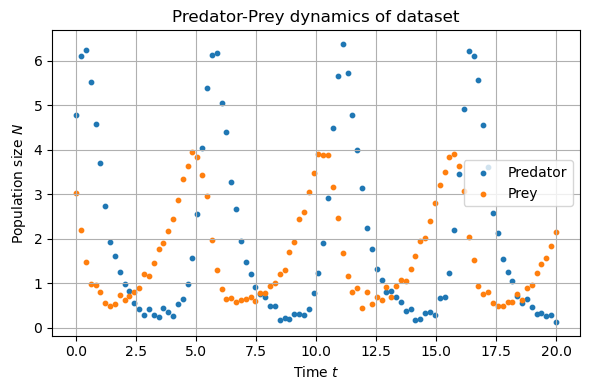

In [143]:
plt.figure(figsize=(6, 4), layout='tight')
plt.scatter(data['t'], data['x'], s=10, label='Predator')
plt.scatter(data['t'], data['y'], s=10, label='Prey')
plt.title('Predator-Prey dynamics of dataset')
plt.xlabel('Time $t$')
plt.ylabel('Population size $N$')
plt.legend()
plt.grid(True)
plt.savefig('media/dataset.png')
plt.show()

In [152]:
def solve_lv(params, init_conditions, t):
    alpha, beta, gamma, delta = params

    def lv_odes(y, t):
        x, z = y
        dxdt = alpha*x - beta*x*z
        dzdt = delta*x*z - gamma*z
        return np.array([dxdt, dzdt])

    solution = odeint(lv_odes, init_conditions, t)
    return solution

In [153]:
def get_initial_random_guess(lower_bound=LOW_PARAM_BOUND, upper_bound=UP_PARAM_BOUND):
    alpha = random.uniform(lower_bound, upper_bound)
    beta = random.uniform(lower_bound, upper_bound)
    gamma = random.uniform(lower_bound, upper_bound)
    delta = random.uniform(lower_bound, upper_bound)
    return [alpha, beta, gamma, delta]

In [154]:
def get_neighbors(solution, step_size=0.1):
    """Calculate the neighbors of a solution, given a step size."""
    neighbors = []
    for i in range(len(solution)):
        # Add step_size to the parameter if it doesn't exceed PARAM_MAX
        if solution[i] + step_size <= UP_PARAM_BOUND:
            neighbors.append(
                [solution[j] if j != i else solution[i] + step_size for j in range(len(solution))])
        # Subtract step_size from the parameter if it doesn't become less than PARAM_MIN
        if solution[i] - step_size >= LOW_PARAM_BOUND:
            neighbors.append(
                [solution[j] if j != i else solution[i] - step_size for j in range(len(solution))])
    return neighbors


def choose_next_step(loss_function, current_step):
    neighbors = get_neighbors(current_step)
    return min(neighbors, key=loss_function)


def hill_climbing(loss_function, initial_step, max_steps):
    """Perform the Hill Climbing optimization algorithm."""
    current_step = initial_step
    history = [current_step]

    for _ in range(max_steps):
        try:
            next_step = choose_next_step(loss_function, current_step)
            if loss_function(next_step) >= loss_function(current_step):
                break
            history.append(next_step)
            current_step = next_step
        except Exception as e:
            print(f"An error occurred during the hill climbing: {str(e)}")
            break

    return current_step, history

In [155]:
def mse_objective(params):
    initial_conditions = [data['y'][0], data['x'][0]]
    simulated = solve_lv(params, initial_conditions, data['t'])
    mse = np.mean((simulated - data[['y', 'x']].values) ** 2)
    return mse


def mae_objective(params):
    initial_conditions = [data['y'][0], data['x'][0]]
    simulated = solve_lv(params, initial_conditions, data['t'])
    mae = np.mean(abs(simulated - data[['y', 'x']].values))
    return mae

In [157]:
bounds = [(LOW_PARAM_BOUND, UP_PARAM_BOUND)] * 4
initial_guess = get_initial_random_guess()

hc_mse_params, _ = hill_climbing(
    mse_objective, initial_guess, max_steps=MAX_STEPS_HILLCLIMING)
print(
    f"HC (MSE) params: {hc_mse_params} with loss {mse_objective(hc_mse_params):.3e}")

hc_mae_params, _ = hill_climbing(
    mae_objective, initial_guess, max_steps=MAX_STEPS_HILLCLIMING)
print(
    f"HC (MAE) params: {hc_mae_params} with loss {mae_objective(hc_mae_params):.3e}")

sa_mse_params = dual_annealing(
    mse_objective, bounds=bounds, maxiter=MAX_ITER_SA, seed=SEED)
print(
    f"SA (MSE) params: {sa_mse_params.x} with loss {mse_objective(sa_mse_params.x):.3e}")

sa_mae_params = dual_annealing(
    mae_objective, bounds=bounds, maxiter=MAX_ITER_SA, seed=SEED)
print(
    f"SA (MAE) parmams: {sa_mae_params.x} with loss {mae_objective(sa_mae_params.x):.3e}")

HC (MSE) params: [0.06985430599839182, 0.44663771870700575, 1.5858382961574196, 0.18112145720671338] with loss 4.053e+00
HC (MAE) params: [0.06985430599839182, 0.5466377187070057, 1.4858382961574195, 0.08112145720671338] with loss 1.360e+00


/opt/homebrew/Caskroom/miniconda/base/envs/ss-assignment-3/lib/python3.11/site-packages/scipy/integrate/_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


SA (MSE) params: [0.85987209 0.43969725 2.         1.15808811] with loss 9.630e-03


/opt/homebrew/Caskroom/miniconda/base/envs/ss-assignment-3/lib/python3.11/site-packages/scipy/integrate/_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
/opt/homebrew/Caskroom/miniconda/base/envs/ss-assignment-3/lib/python3.11/site-packages/scipy/integrate/_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
/opt/homebrew/Caskroom/miniconda/base/envs/ss-assignment-3/lib/python3.11/site-packages/scipy/integrate/_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
/opt/homebrew/Caskroom/miniconda/base/envs/ss-assignment-3/lib/python3.11/site-packages/scipy/integrate/_o

SA (MAE) parmams: [0.88256932 0.45742298 1.94325766 1.11739819] with loss 8.287e-02


In [ ]:
# Plot the results

Removing samples functionality

## Experiments and plots

#### How many data-points from each time-series you could remove until you are not able to reverse-engineer the parameters any more?

First, try to ﬁnd the importance of each time-series on reverse-engineering process by ﬁxing one time-series and removing data-points from the other one. In this way, you will ﬁnd the critical number of data-points for each time-series.

Then, if you combine two reduced time-series, could you still infer the parameters?

Does removing every data-point have the same effect on reverse-engineering process? In other words, what are the points that you could remove safely without affecting the inferance procedure? and what are those with critical effects on the process?

#### \<Extra question\>